In [1]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet" / "Virk2Vec" / "data"

### Setting up: Bankruptcy ground truth

In [47]:
# load data 
registration_folder = DATA_ROOT / "Tables" / "Registrations"
registration_files = [file for file in os.listdir(registration_folder) if file.endswith('.csv')]
registrations = pd.concat([pd.read_csv(os.path.join(registration_folder, file), index_col=0) for file in registration_files])

# filter status data
targets_all = ['UNDER KONKURS', "TVANGSOPLØST", "OPLØST EFTER KONKURS"]
registrations = registrations.loc[registrations.ChangeType == 'Status']
registrations = registrations.loc[registrations.NewValue.isin(targets_all)]

tvang_registrations = registrations.loc[registrations.NewValue.isin(["UNDER KONKURS"])][['CVR', 'FromDate', 'NewValue']]
u_konkurs_registrations = registrations.loc[registrations.NewValue.isin(["TVANGSOPLØST"])][['CVR', 'FromDate', 'NewValue']]

# assert no intersection between the two status types on CVR. 
intersect = set(tvang_registrations.CVR).intersection(set(u_konkurs_registrations.CVR))
df_bankrupt = pd.concat([tvang_registrations, u_konkurs_registrations]).sort_values('FromDate', ascending=True).drop_duplicates('CVR', keep='first')

# add the opløst efter konkurs
rest = registrations.loc[~registrations.CVR.isin(df_bankrupt.CVR)]
print(len(rest))
rest = rest.loc[rest.NewValue.isin(["OPLØST EFTER KONKURS"])]
print(len(rest))

df_bankrupt = pd.concat([df_bankrupt, rest[['CVR', 'FromDate', 'NewValue']]]).rename(columns={'FromDate': 'bankrupt_date', 'NewValue': 'bankrupt_type'})

21
21


### Setting up: Employee data

In [50]:
# load data 
employee_folder = DATA_ROOT / "Tables" / "EmployeeCounts"
employee_files = [file for file in os.listdir(employee_folder) if file.endswith('.csv')]
employees = pd.concat([pd.read_csv(os.path.join(employee_folder, file), index_col=0) for file in employee_files])

In [51]:
employees['Year'] = employees['FromDate'].str[:4].astype(int)
employees = employees.groupby(['CVR','Year']).mean().reset_index()

### Setting up: Financial data

In [5]:
finance_folder = DATA_ROOT / "Tables" / "Financials"
finance_files = [file for file in os.listdir(finance_folder) if file.endswith('.csv')]
financials_all = pd.concat([pd.read_csv(os.path.join(finance_folder, file), index_col=0) for file in finance_files])

# merge with bankrupt data and employee data
financials_all['PublicationYear'] = financials_all['PublicationDate'].str[:4].astype(int)
financials_all = financials_all.merge(df_bankrupt, left_on='CVR', right_on='CVR', how='left')
financials_all['BankruptYear'] = pd.to_numeric(financials_all.bankrupt_date.str[:4], errors='coerce')
financials_all['bankrupt_type'] = financials_all['bankrupt_type'].fillna('NOT BANKRUPT')
financials_all['SameYearAsBankrupt'] = financials_all['PublicationYear'] == financials_all['BankruptYear']

financials_all = financials_all.merge(employees, left_on=['CVR', 'PublicationYear'], right_on=['CVR', 'Year'], how='left')

In [6]:
# format columns
financials_all['EmployeeBenefitsExpense'] = financials_all['EmployeeBenefitsExpense'].abs()
financials_all['Assets'] = financials_all['EmployeeBenefitsExpense'].abs()
financials_all['ProfitLoss'] = pd.to_numeric(financials_all['ProfitLoss'], errors='coerce')

# filter out outliers in profitloss
financials_all = financials_all.loc[financials_all['ProfitLoss'] < 1e21]

# filter out non-bankrupt entries
financials_bankrupt = financials_all.loc[~financials_all['BankruptYear'].isna()]
financials_bankrupt = financials_bankrupt.loc[financials_bankrupt['BankruptYear'] > 2013]
financials_bankrupt['YearsToBankruptcy'] = financials_bankrupt['PublicationYear'] - financials_bankrupt['BankruptYear']


### Viz 1: Increasing Profits As Employee Counts Grow (for smaller companies)
- subset: 0-10 employees
- profitloss between -10 mio -> 10 mio
- Profitloss from annual reports across 2013-2023 versus the mean employee count of the company in the year of publication.

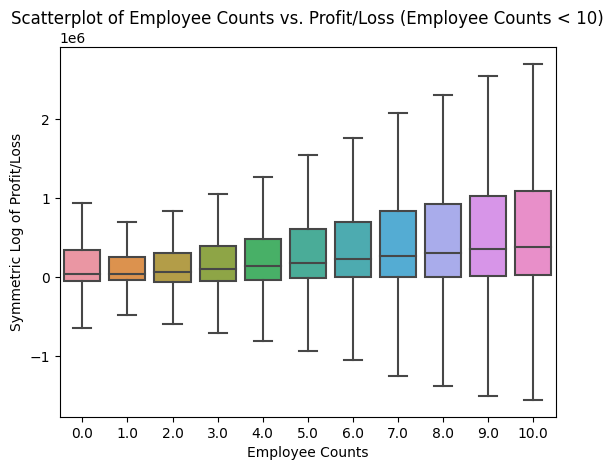

In [32]:
financials_all['EmployeeCountsInt'] = np.round(financials_all['EmployeeCounts'])
# Apply symmetric log transformation to the ProfitLoss column
employee_range = (0,10)
profitloss_range = (-1e8, 1e8)
subset = financials_all.loc[(financials_all.ProfitLoss > profitloss_range[0]) & (financials_all.ProfitLoss < profitloss_range[1]) & (financials_all.EmployeeCounts >= employee_range[0]) & (financials_all.EmployeeCounts < employee_range[1])]

sns.boxplot(data=subset, x='EmployeeCountsInt', y='ProfitLoss', showfliers=False)
plt.xlabel('Employee Counts')
plt.ylabel('Symmetric Log of Profit/Loss')
plt.title('Scatterplot of Employee Counts vs. Profit/Loss (Employee Counts < 10)')
plt.show()

### Viz 2: Increasing Profits As Employee Counts Grow (for larger companies)
- subset: 0-10 employees
- profitloss between -10 mia -> 10 mia
- Profitloss from annual reports across 2013-2023 versus the mean employee count of the company in the year of publication.

/var/folders/q1/1q4ncmgd7qz50d0x1z41czmh0000gn/T/ipykernel_41744/235083754.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['EmployeeCountsBin'] = pd.cut(subset['EmployeeCounts'], bins=bins, labels=bin_names)


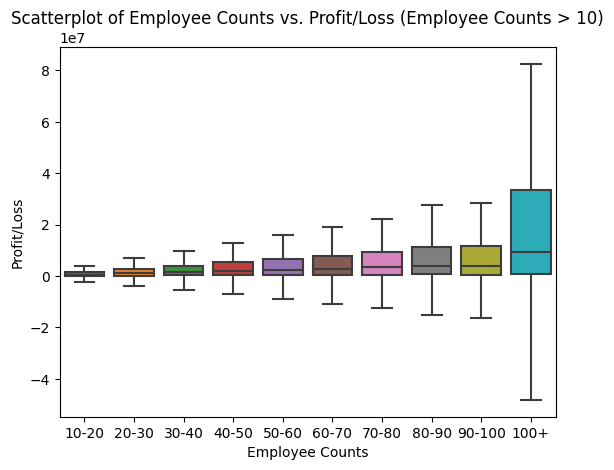

In [33]:
employee_range = (10,np.inf)
profitloss_range = (-1e10, 1e10)
subset = financials_all.loc[(financials_all.ProfitLoss > profitloss_range[0]) & (financials_all.ProfitLoss < profitloss_range[1]) & (financials_all.EmployeeCounts >= employee_range[0]) & (financials_all.EmployeeCounts < employee_range[1])]

# create a column with custom bins
bin_names = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+']
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
subset['EmployeeCountsBin'] = pd.cut(subset['EmployeeCounts'], bins=bins, labels=bin_names)

sns.boxplot(data=subset, x='EmployeeCountsBin', y='ProfitLoss', showfliers=False)
plt.xlabel('Employee Counts')
plt.ylabel('Profit/Loss')
plt.title('Scatterplot of Employee Counts vs. Profit/Loss (Employee Counts > 10)')
plt.show()

### Viz 3: Employee Counts when Companies Go bankrupt

Text(0.5, 1.0, 'Employee Count In Year Of Bankruptcy')

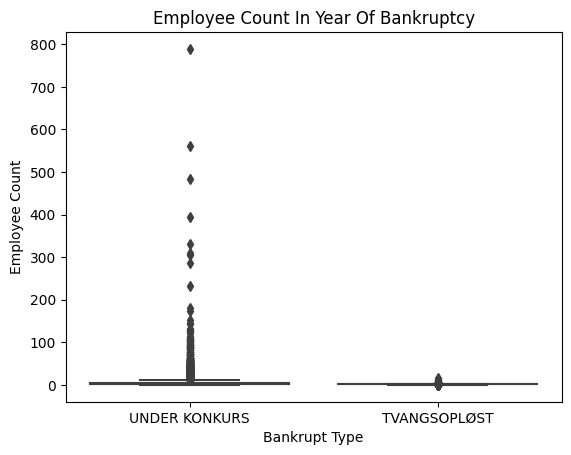

In [61]:
df_bankrupt['Year'] = df_bankrupt['bankrupt_date'].str[:4].astype(int)
test = df_bankrupt.merge(employees, left_on=['CVR', 'Year'], right_on=['CVR', 'Year'], how='left').dropna(subset='EmployeeCounts')
test = test.loc[test.bankrupt_type != 'OPLØST EFTER KONKURS']
sns.boxplot(data=test, x='bankrupt_type', y='EmployeeCounts', showfliers=True)
plt.xlabel('Bankrupt Type')
plt.ylabel('Employee Count')
plt.title('Employee Count In Year Of Bankruptcy')

<AxesSubplot: >

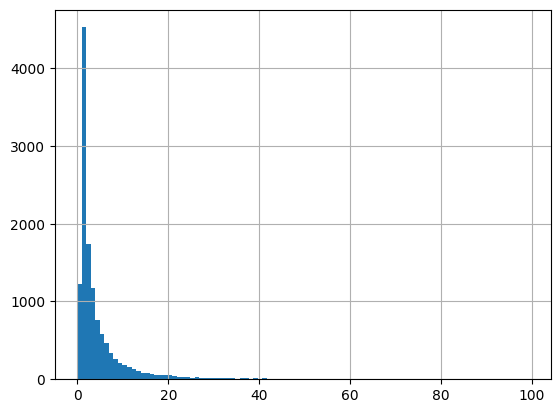

In [65]:
test.loc[test.EmployeeCounts < 100].EmployeeCounts.hist(bins=100)

In [66]:
len(test.loc[test.EmployeeCounts > 20])

580

In [52]:
employees

,CVR,Year,EmployeeCounts
0,10000025,2000,1.50
1,10000025,2001,1.00
2,10000025,2002,1.25
3,10000025,2003,1.00
4,10000025,2004,1.00
...,...,...,...
2051627,99862068,2021,0.00
2051628,99862068,2022,0.00
2051629,99862068,2023,0.00
2051630,99862068,2024,0.00
